In [151]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics


print("Import Complete")

Import Complete


In [152]:
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open( name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [153]:
def label_features(df, features_master):
        for i,row in df.iterrows():
            #message = pruning_dict.remove_nonalphanumeric(row.text)
            message = str(row.question_class)
            features = build_vocabulary([message], word_drop=False) & features_master
            features = features + features_master
            features = list(np.array(list(features.values())) - 1)
            df.set_value(i,'features',features)
        return df
    
def build_vocabulary(messages, word_drop=True):
    cvocabularies = Counter()
    #print("building vocabulary from {} messages".format(len(messages)))
    for start in range(0, len(messages), 500):
        vocabulary = Counter()
        for message in messages[start:start + 500]:
            message = str(message)
            #message = remove_nonalphanumeric(message)
            message_split = message.split()
            gram_count = 3
            grams = []
            for i in range(len(message_split) - (gram_count - 1)):
                gram = ''
                for n in range(gram_count):
                    gram = gram + message_split[i+n] + ' '
                grams.append(gram[:-1])
            vocabulary = vocabulary + Counter(message_split) + Counter(grams)
        cvocabularies = cvocabularies + vocabulary
    if word_drop == True:
        for key, count in dropwhile(
                                    lambda key_count: key_count[1] >= (len(messages) * .01),
                                    cvocabularies.most_common()):
            del cvocabularies[key]
    #print("The vocabulary contains {} words".format(len(cvocabularies)))
    return cvocabularies

In [154]:
def cluster(df, df2, N, v=False):
    #print("Start loop")
    #gpercentages = []
    #singles = 0
    clusterer = KMeans(n_clusters=N)
    clusterer.fit(df2)
    transform = clusterer.transform(df2)
    
    
    d_center = []
    cluster = []
    for x in transform:
        d_center.append(min(x)**2)
        cluster.append(np.argmin(x))
    df['cluster'] = cluster
    df['d_from_center'] = d_center
    d_center = np.array(d_center)
    mean = np.mean(d_center)
    std = np.std(d_center)

    print("Mean: {}".format(round(mean, 3)))
    print("STD: {}".format(round(std, 3)))
    print("")

  

    if v == True:
        for cgroup in range(N):
            group = df.groupby('cluster').get_group(cgroup)
            print_clusters(group)

    
    return df

def print_clusters(group):
    std = np.std(list(group.d_from_center))
    print("Found {} messages of the same form.   STD: {}".format(len(group), std))
    for message in group.question_class.head(5):
        if group.question_class.count() > 1:
            print(message)
            print("")
    print("")

In [155]:
def plot_clusters(df, N):
    features = list(df.features)
    svd = TruncatedSVD(n_components=2, n_iter=2, random_state=42)
    #svd =  PCA(n_components=2)

    transformed = pd.DataFrame(svd.fit_transform(features), columns=["plot_cordX", "plot_cordY"])
    meanX = transformed["plot_cordX"].mean()
    meanY = transformed["plot_cordY"].mean()
    transformed["plot_cordX"] = transformed["plot_cordX"].divide(meanX) - 1
    transformed["plot_cordY"] = transformed["plot_cordY"].divide(meanY) - 1
    meanX = transformed["plot_cordX"].mean()



    df["plot_cordX"] = transformed.plot_cordX
    df["plot_cordY"] = transformed.plot_cordY

    q = df["plot_cordX"].quantile(0.9)
    df = df[df["plot_cordX"] < q]
    q = df["plot_cordY"].quantile(0.9)
    df = df[df["plot_cordY"] < q]


    for n in range(N):
        plt.scatter(df[df["cluster"] == n].plot_cordX, df[df["cluster"] == n].plot_cordY, label="Class " + str(n))



    #plt.legend()
    plt.show()



Explained variance of the SVD step: 40%
465
Mean: 0.769
STD: 0.141

Found 2219 messages of the same form.   STD: 0.110116548029
question use intellectual property employment ends please give call

several questions following topics

eeo report due new company appears last completed eeo report september data research internet states report due correct

state illinois state mandated lunch break required hourly employees

looking sample whistleblower policy small person ria registered investment advisor firm


Found 556 messages of the same form.   STD: 0.149857443435
allow employees day personal loa job protected loa days offer cobra elect sign cobra pay reinstate coverage deny opportunity continue coverage lack payment

employer decides self administer cobra required collect cobra admin fee decide waive

hello ee enrolled cobra left employment months ago effective medical supplement eff would like cancel cobra eff allowed simply submit cancellation letter carrier realize stops paying pr

C:\Users\kerri\Anaconda2\envs\thinkhr\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


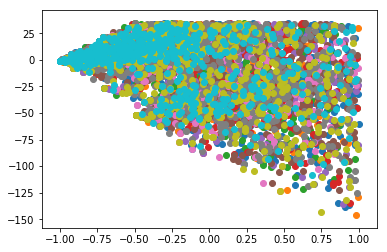

In [156]:
csvdata = "./data/subcategory_2_think_hr_v2.csv"
df = pd.read_csv(csvdata)
df = df[['question_class']][:10000]
df = df.dropna()

N = 10




vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.7 
                                 )
X = vectorizer.fit_transform(list(df.question_class))


svd = TruncatedSVD(n_components=75)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)
df["features"] = list(X)


explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

print(len(vectorizer.vocabulary_) )

cluster(df, X, N, v=True)


vocab = load_obj('final_feature_set')
features_master = Counter(vocab)
df["features"] = [[0] * len(vocab)] * len(df)
df = label_features(df, features_master)


plot_clusters(df, N)

